In [13]:
DIR_NAME = "DRIVER_DATA"

# Import source
cd("../Source")
@everywhere include("ChiralMC.jl")
@everywhere using ChiralMC
@everywhere using Base.Test

@everywhere include("functions_msc.jl")
@everywhere include("functions_observables.jl")
@everywhere include("functions_thermalization.jl")

using Base.Test
using Plots
using Distributions

include("functions_plots_and_files.jl")
cd("../Notebooks/")

# Goto work dir
if !isdir("./$(DIR_NAME)")
    mkdir("./$(DIR_NAME)")
end
cd("./$(DIR_NAME)")

LoadError: [91mchdir ../Source: no such file or directory (ENOENT)[39m

# Setup System

In [2]:
THERM_FRAC = 1/10
DT_MAX = 10000

@everywhere const two_pi = 2π

# We run a simulation with the parameters
g = 0.3    # Gauge coupling
ν = 0.3    # Anisotropy
H = 0.005   # External field

# Other parameters
L = 12     # System length
T = 0.12 #0.11039   # Temperature
γ = 1.0    # Order parameter amplitud
κ₅ = 1.0

# Calculate periodic boundary conditioned f s.t. fL ∈ N
f = ceil(abs(H/(2π)*L))/L*sign(H)
println("f set to $(f)")
# Calculate inverse temperature
β = 1/T
println("β set to $(β)")

# Create system
syst = SystConstants(L, L, γ, 1/g^2, ν, κ₅, f, β)
sim = Controls(π/3, 0.4, 3.0)

# Measurement parameters
M = 300    # Number of measurements
Δt = 400  # Interval between measurements (MCS)
# Construct k-matrix where the horizontal axis contains kx ∈ [-π, π), while
# the vertical axis contain ky ∈ [-π, π) at the second component
k_matrix = [[2π/L*(x-1-L/2), 2π/L*(L/2-y)] for y=1:L, x=1:L];

f set to 0.08333333333333333
β set to 8.333333333333334


# Thermalization

In [3]:
println("\nTesting Thermalization\n----------------------------------------------------------------")
ψ₁ = State(1, syst)
ψ₂ = State(2, syst)
println("Checking that a random state has lower energy than a completely correlated state")
println(@test E(ψ₁) < E(ψ₂))
(t₀, tₛ, T, E_ref, E_w, ψ_ref, ψ_w, sim_ref, sim_w) = parallelThermalization!(ψ₂, [ψ₁], syst, Controls())
@show t₀


Testing Thermalization
----------------------------------------------------------------
Checking that a random state has lower energy than a completely correlated state
Test Passed
Number of parallel workers: 0
Thermalization will be ×2 as long.
Increasing simulation time such that tₛ = 1001 and T = 1802
Increasing simulation time such that tₛ = 1802 and T = 3244
Increasing simulation time such that tₛ = 3244 and T = 5840
Increasing simulation time such that tₛ = 5840 and T = 10512
Worker 1 initially thermalised after 6358 steps
All workers initially thermalized after 10512 steps
Checking average ∈ [10513, 17650]
Problem for worker 1: ΔE = 18.94407015838752 ± 13.478362854237892
Increasing simulation time to T = 27644
Checking average ∈ [17651, 27644]
Problem for worker 1: ΔE = 9.0741303212251 ± 13.573452694809266
Increasing simulation time to T = 41636
Checking average ∈ [27645, 41636]
Thermalization successful between T = [27645, 41636]
Worker 1: ΔE = 2.3193661072560885 ± 12.55888465

60396

In [4]:
typeof(E_w)

Array{Float64,2}

In [7]:
using Plots
pyplot()

Plots.PyPlotBackend()

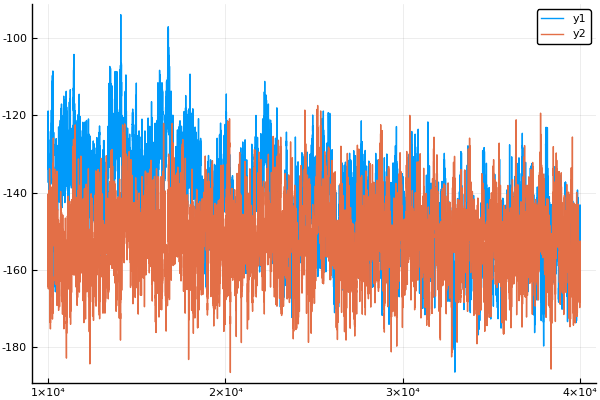

In [11]:
int = 10000:4*10^4
plot(int, [E_ref[int], E_w[1,int]])

In [3]:
(t₀, ψ_ref, sim_ref, ψ_w, sim_w) = initializeParallelStatesS(syst, sim);

Thermalizing 4 states
Number of parallel workers: 3
Increasing simulation time such that tₛ = 1001 and T = 1802
Worker 1 initially thermalised after 1478 steps
Worker 2 initially thermalised after 1400 steps
Worker 3 initially thermalised after 1423 steps
All workers initially thermalized after 1802 steps
Checking average ∈ [1803, 5053]
Thermalization successful between T = [1803, 5053]
Worker 1: ΔE = 0.13127132894140217 ± 8.489789164530587
Worker 2: ΔE = 0.5168041985473372 ± 7.9225395502293905
Worker 3: ΔE = 0.25097781607315817 ± 7.835959121345939
Final thermalization time: 16293
119.536762 seconds (108.13 M allocations: 4.100 GiB, 2.00% gc time)
Calculating energies and acceptance rates
Saving plots to files


In [23]:
@everywhere include("../../Source/functions_observables.jl")

In [16]:
av_u⁺, av_u⁻ = meanAmplitudes(ψ_ref)
max_u⁺, min_u⁺, max_u⁻, min_u⁻ = maxMinAmplitudes(ψ_ref)
println("Amplitudes of reference state:\n⟨u⁺⟩ =\t$(av_u⁺)\t\t\t⟨u⁻⟩ =\t$(av_u⁻)\nmax(u⁺) =\t$(max_u⁺)\t\tmax(u⁻) =\t$(max_u⁻)
min(u⁺) =\t$(min_u⁺)\t\tmin(u⁻) =\t$(min_u⁻)")

Amplitudes of reference state:
⟨u⁺⟩ =	5.786729803433406			⟨u⁻⟩ =	5.915049352459818
max(u⁺) =	1.228917659884519		max(u⁻) =	1.2741042296198917
min(u⁺) =	0.0005333505571339936		min(u⁻) =	0.0001319733853111793


In [17]:
println("Writing system:\ng\t=\t$(g)\nν\t=\t$(ν)\nH\t=\t$(H)\nL\t=\t$(L)\nT\t=\t$(T)")
println("γ\t=\t$(γ)\nM\t=\t$(M)\nt₀\t=\t$(t₀)\nΔt\t=\t$(Δt)\nf\t=\t$(f)")
writeSimulationConstants(syst, sim, M, t₀, Δt)

# Saving the reference state and the first worker state
save(ψ_ref, "state_ref")
save(ψ_w[1], "state_w")


Writing system:
g	=	0.3
ν	=	0.3
H	=	0.005
L	=	12
T	=	41636
γ	=	1.0
M	=	300
t₀	=	60396
Δt	=	400
f	=	0.08333333333333333
Saving state to file state_ref
Saving state to file state_w


1

# Measuring Vortex Lattice

In [24]:
# Including ψ_ref in the list of states as the last state
ψ_list = vcat(ψ_w, [ψ_ref])
Δt = min(DT_MAX, ceil(Int64, t₀*THERM_FRAC))
println(Δt)
println("\nMeasuring structure function and vortex lattice
--------------------------------------------------------------------------------------")
@time (av_V⁺, err_V⁺, V⁺, av_V⁻, err_V⁻, V⁻, av_S⁺, err_S⁺, S⁺, av_S⁻, err_S⁻, S⁻) = parallelSFVLA!(k_matrix, ψ_list, sim_ref, M, Δt);

6040

Measuring structure function and vortex lattice
--------------------------------------------------------------------------------------
Starting 300 measurements on 1 processes doing max 300 measurements each
on a 12×12 system, corresponding to 1812000 MCS pr. process
Measurement progress: 10%


LoadError: [91mInterruptException:[39m

In [7]:
plotStructureFunctionVortexLatticeS(av_V⁺, av_V⁻, V⁺[rand(1:M)], V⁻[rand(1:M)], av_S⁺, av_S⁻, k_matrix)

S⁺(0) ≈ 1.0000000000000002
S⁻(0) ≈ 1.0000000000000002
The proportion of vortices (n⁺, n⁻) in snapshot
% of vortex kind (-1, -1): 	3
% of vortex kind (-1, 0): 	9
% of vortex kind (-1, 1): 	3
% of vortex kind (0, -1): 	12
% of vortex kind (0, 0): 	41
% of vortex kind (0, 1): 	14
% of vortex kind (1, -1): 	2
% of vortex kind (1, 0): 	11
% of vortex kind (1, 1): 	5

Sum of + component vorticity in the snapshot: 30.00000000000001
Sum of - component vorticity in the snapshot: 30.000000000000007


1

In [8]:
pwd()

"/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Notebooks/DRIVER_DATA"

# Plotting vortices

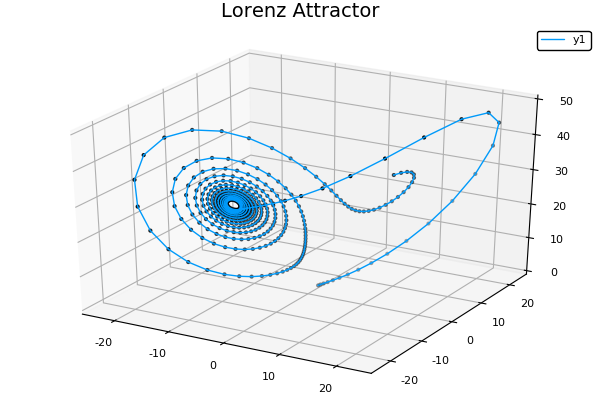

In [32]:
# define the Lorenz attractor
mutable struct Lorenz
    dt; σ; ρ; β; x; y; z
end

function step!(l::Lorenz)
    dx = l.σ*(l.y - l.x)       ; l.x += l.dt * dx
    dy = l.x*(l.ρ - l.z) - l.y ; l.y += l.dt * dy
    dz = l.x*l.y - l.β*l.z     ; l.z += l.dt * dz
end

attractor = Lorenz([dt = 0.02, σ = 10., ρ = 28., β = 8//3, x = 1., y = 1., z = 1.]...)


# initialize a 3D plot with 1 empty series
plt = plot3d(1, xlim=(-25,25), ylim=(-25,25), zlim=(0,50), title = "Lorenz Attractor", marker = 2)

for i = 1:500
    step!(attractor)
    push!(plt, attractor.x, attractor.y, attractor.z)
end
display(plt)
